In [0]:
z.jup()

Download ipynb

In [0]:
import requests
import io
import torch
import os
import time
from flask import Flask, request, jsonify
from langchain_community.llms import LlamaCpp
from langchain.callbacks import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from huggingface_hub import hf_hub_download
from langchain_community.document_loaders import TextLoader, PyPDFLoader, PDFMinerPDFasHTMLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.vectorstores import InMemoryVectorStore

Imported requests 2.32.3 (pre-installed)
Imported io (pre-installed)
Imported torch 2.5.1+cu121 (pre-installed)
Imported os (pre-installed)
Imported flask 3.0.3 (pre-installed)
Imported langchain_community.llms (pre-installed)
Imported langchain.callbacks (pre-installed)
Imported langchain.prompts (pre-installed)
Imported huggingface_hub 0.25.2 (pre-installed)
Imported langchain_community.document_loaders (pre-installed)
Imported langchain.text_splitter (pre-installed)
Imported langchain_core.output_parsers (pre-installed)
Imported langchain_core.vectorstores (pre-installed)


In [0]:
from underthesea import word_tokenize

def preprocess_text(text):
    return ' '.join(word_tokenize(text))

Imported underthesea 6.8.4 (pre-installed)


In [0]:
# Lựa chọn n_layer tối ưu. Dựa trên dung lượng VRAM đang trống. 
# Với Gemma 2 9b, Mỗi layer chiếm khoảng 240MB 

# Xóa llm 
if 'llm' in locals(): del llm

# Lấy VRAM còn trống 
_, free_GPUs = z.showUsage()
print(f'Free VRAM: {free_GPUs[0]}MB')

n_gemma_layer = int(free_GPUs[0] / 240)

if n_gemma_layer == 0:
    print(f'Sufficient VRAM (n_layer=={n_gemma_layer}), use CPU')
    n_gemma_layer = None
else:
    if n_gemma_layer > 43:
        n_gemma_layer = 43
    print(f'Optimize n_layer: {n_gemma_layer}')

Imported psutil 6.0.0 (pre-installed)
Imported torch 2.5.1+cu121 (pre-installed)
---CPU---
#0: 4.6%	#1: 0.0%	#2: 0.0%
#3: 1.6%	#4: 0.0%	#5: 0.0%
#6: 1.6%	#7: 0.0%	#8: 0.0%
#9: 0.0%	#10: 0.0%	#11: 0.0%
#12: 0.0%	#13: 0.0%	#14: 0.0%
#15: 0.0%	#16: 0.0%	#17: 7.9%
#18: 0.0%	#19: 0.0%

---Memory---
34633MiB (53%) free, 65237MiB total

---GPU---
#0. Tesla P100-PCIE-16GB
memory: 10761MiB (66%) free, 16287MiB total
Free VRAM: 10761MB
Optimize n_layer: 43


In [0]:
callbacks = [StreamingStdOutCallbackHandler()]
path_model = hf_hub_download(repo_id="bartowski/gemma-2-9b-it-GGUF", filename="gemma-2-9b-it-Q8_0_L.gguf")

llm = LlamaCpp(
    model_path=path_model,
    temperature=0.3,
    n_ctx = 8192,
    max_tokens = 500,
    n_gpu_layers=40,
    callback_manager=callbacks,
    verbose = True,
)

llama_model_loader: loaded meta data with 33 key-value pairs and 464 tensors from z:/hf/.cache/hub\models--bartowski--gemma-2-9b-it-GGUF\snapshots\d731033f3dc4018261fd39896e50984d398b4ac5\gemma-2-9b-it-Q8_0_L.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma2
llama_model_loader: - kv   1:                               general.name str              = gemma-2-9b-it
llama_model_loader: - kv   2:                      gemma2.context_length u32              = 8192
llama_model_loader: - kv   3:                    gemma2.embedding_length u32              = 3584
llama_model_loader: - kv   4:                         gemma2.block_count u32              = 42
llama_model_loader: - kv   5:                 gemma2.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                gemma2.attention.head_co

In [0]:
local_filetext = 'sotaySV.txt'
loader = TextLoader(local_filetext, encoding='utf-8')
docs = loader.load()

In [0]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=768,
    chunk_overlap=300,
    is_separator_regex=False
)
    
splits = text_splitter.split_documents(docs)
print(len(splits))

38


In [0]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cuda'}
embedding = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
)

Imported langchain_community.embeddings (pre-installed)


In [0]:
from langchain.vectorstores import Chroma

persist_directory = 'SoTaySVChatBotDB'

vectordb = Chroma.from_documents(documents=splits, embedding=embedding, persist_directory = persist_directory)
vectordb.persist()
vectordb = None

vectordb = Chroma(persist_directory = persist_directory, embedding_function = embedding)

C:\Users\zeppelin\AppData\Local\Temp\zeppelin_pyspark-470084389741299795.py:937: LangChainDeprecationWarning: Importing Chroma from langchain.vectorstores is deprecated. Please replace deprecated imports:

>> from langchain.vectorstores import Chroma

with new imports of:

>> from langchain_community.vectorstores import Chroma
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/v0.2/docs/versions/v0_2/>
Imported langchain.vectorstores (pre-installed)
<stdin>:1: LangChainDeprecationWarning: Importing Chroma from langchain.vectorstores is deprecated. Please replace deprecated imports:

>> from langchain.vectorstores import Chroma

with new imports of:

>> from langchain_community.vectorstores import Chroma
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/v0.2/docs/versions/v0_2/>


In [0]:
from langchain_community.cache import SQLAlchemyCache
from sqlalchemy import Column, Computed, Index, Integer, Sequence, String, DateTime, create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy_utils import TSVectorType
from sqlalchemy.orm import sessionmaker
import json
from datetime import datetime
from sqlalchemy import create_engine
from sqlalchemy import Boolean

username = 'io21110600'
password = 'Yur288a10gw7'
host = '192.168.236.128'  
port = '5432'
database = 'studentdb'
connection_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'
schema = 'db21110600'

Base = declarative_base()
class FulltextLLMCache(Base):
    __tablename__ = "llm_cache_fulltext"
    id = Column(Integer, Sequence("cache_id"), primary_key=True)
    prompt = Column(String, nullable=False)
    llm = Column(String, nullable=False)
    idx = Column(Integer)
    response = Column(String)
    prompt_tsv = Column(
        TSVectorType(),
        Computed("to_tsvector('simple', llm || ' ' || prompt)", persisted=True),
    )
    
    __table_args__ = (
        Index("idx_fulltext_prompt_tsv", prompt_tsv, postgresql_using="gin"),
    )
class QuestionCount(Base):
    __tablename__ = "question_count"
    id = Column(Integer, Sequence("count_id_seq"), primary_key=True)
    question_embedding = Column(String, nullable=False)  # Hoặc một kiểu dữ liệu phù hợp cho embedding
    count = Column(Integer, default=1)  # Số lần hỏi
    
class FAQ(Base):
    __tablename__ = "faq"
    id = Column(Integer, Sequence("faq_id_seq"), primary_key=True)
    question = Column(String, nullable=False)
    answer = Column(String, nullable=False)
    embedding = Column(String, nullable=False)

from sqlalchemy import Boolean

class Feedback(Base):
    __tablename__ = "feedback"
    id = Column(Integer, Sequence("feedback_id_seq"), primary_key=True)
    question = Column(String, nullable=False)
    embedding_question = Column(String, nullable=False)
    response_1 = Column(String, nullable=False)
    response_2 = Column(String, nullable=False)
    embedding_1 = Column(String, nullable=False)
    embedding_2 = Column(String, nullable=False)
    likes_1 = Column(Integer, default=0)  # Lượt thích cho phản hồi 1
    dislikes_1 = Column(Integer, default=0)  # Lượt không thích cho phản hồi 1
    likes_2 = Column(Integer, default=0)  # Lượt thích cho phản hồi 2
    dislikes_2 = Column(Integer, default=0)  # Lượt không thích cho phản hồi 2
    t = Column(DateTime, default=datetime.utcnow)  # Thời điểm lưu phản hồi

engine = create_engine(connection_string, connect_args={'options': f'-csearch_path={schema}'})

Session = sessionmaker(bind=engine)
session = Session()
#Base.metadata.create_all(bind=engine)
session.close

Imported langchain_community.cache (pre-installed)
Imported sqlalchemy 2.0.31 (pre-installed)
Imported sqlalchemy.ext.declarative (pre-installed)
Imported sqlalchemy_utils 0.41.2 (pre-installed)
Imported sqlalchemy.orm (pre-installed)
Imported json (pre-installed)
Imported datetime (pre-installed)
Imported sqlalchemy 2.0.31 (pre-installed)
Imported sqlalchemy 2.0.31 (pre-installed)
Imported sqlalchemy 2.0.31 (pre-installed)
<bound method Session.close of <sqlalchemy.orm.session.Session object at 0x000001998289DC90>>


In [0]:
from langchain.globals import set_llm_cache
set_llm_cache(SQLAlchemyCache(engine, FulltextLLMCache))

Imported langchain.globals (pre-installed)


In [0]:
import json
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
)
def generate_embedding(question):
    try:
        embedding = embedding_model.embed_query(question)
        if embedding is None:
            raise ValueError("Embedding generation failed.")
        return embedding
    except Exception as e:
        print(f"Error in generating embedding: {e}")
        return None
        
def embed_question_and_save(question, answer):
    embedding = generate_embedding(question)
    if embedding is None:
        print("Embedding is None, skipping FAQ insertion.")
        return
    try:
        Session = sessionmaker(bind=engine)
        session = Session()
        embedding_str = json.dumps(list(embedding))  
        new_faq = FAQ(question=question, answer=answer, embedding=embedding_str)
        session.add(new_faq)
        session.commit()
        print(f"FAQ entry for '{question}' saved successfully.")
    except Exception as e:
        print(f"Error in saving FAQ: {e}")
        session.rollback()  
    finally:
        session.close()
        
def feedback_save(question, response0, response1):
    question_embedding = generate_embedding(question)
    embedding0 = generate_embedding(response0)
    embedding1 = generate_embedding(response1)
    if embedding is None:
        print("Embedding is None, skipping Feedback insertion.")
        return
    try:
        Session = sessionmaker(bind=engine)
        session = Session()
        embedding_question = json.dumps(list(question_embedding))
        embedding_str0 = json.dumps(list(embedding0))  
        embedding_str1 = json.dumps(list(embedding1))  
        new_fb = Feedback(question = question, embedding_question = embedding_question, response_1 = response0, response_2 = response1, embedding_1 = embedding_str0, embedding_2 = embedding_str1)
        session.add(new_faq)
        session.commit()
        print(f"Feedback entry for '{question}' saved successfully.")
    except Exception as e:
        print(f"Error in saving Feedback: {e}")
        session.rollback()  
    finally:
        session.close()


Imported json (pre-installed)
Imported langchain_community.embeddings (pre-installed)


In [0]:
import numpy as np

def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    vec1 = vec1[:768] if len(vec1) > 768 else np.pad(vec1, (0, 768 - len(vec1)), 'constant')
    vec2 = vec2[:768] if len(vec2) > 768 else np.pad(vec2, (0, 768 - len(vec2)), 'constant')
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def find_closest_questions(session, user_question):
    user_embedding = generate_embedding(user_question)  # Tạo embedding cho câu hỏi của người dùng
    faqs = session.query(FAQ).all()  # Lấy tất cả các FAQ từ cơ sở dữ liệu
    closest_faq = None  # Biến lưu câu hỏi giống nhất
    second_closest_faq = None  # Biến lưu câu hỏi giống nhì
    highest_similarity = -1  # Độ tương đồng lớn nhất
    second_highest_similarity = -1  # Độ tương đồng lớn nhì

    for faq in faqs:
        faq_embedding = np.array(json.loads(faq.embedding))  # Lấy embedding từ FAQ và chuyển thành numpy array
        similarity = cosine_similarity(user_embedding, faq_embedding)  # Tính toán độ tương đồng giữa user_question và FAQ

        if similarity > highest_similarity:
            # Cập nhật câu hỏi nhì thành câu hỏi nhất hiện tại
            second_highest_similarity = highest_similarity
            second_closest_faq = closest_faq

            # Cập nhật câu hỏi nhất bằng câu hỏi hiện tại
            highest_similarity = similarity
            closest_faq = faq
        elif similarity > second_highest_similarity:
            # Cập nhật câu hỏi nhì nếu độ tương đồng cao hơn
            second_highest_similarity = similarity
            second_closest_faq = faq

    return closest_faq, highest_similarity, second_closest_faq, second_highest_similarity
    
def parse_embedding(embedding_str):
    embedding_str = embedding_str.replace("{", "[").replace("}", "]")
    embedding_list = re.findall(r"[-+]?\d*\.\d+|\d+", embedding_str)  
    embedding_list = [float(x) for x in embedding_list]  
    return np.array(embedding_list, dtype=float)

Imported numpy 2.1.3 (pre-installed)


In [0]:
Session = sessionmaker(bind=engine)
session = Session()

In [0]:
from langchain_core.runnables import RunnablePassthrough

retriever = vectordb.as_retriever(search_kwargs={"k":7})

template = """
{context}

Question: From now on, speak Vietnamese.
Bạn là chatbot tư vấn sinh viên của trường đại học sư phạm kỹ thuật TP.HCM. Dựa vào những gì đã cung cấp, hãy giải đáp các thắc mắc của sinh viên một cách đầy đủ, chính xác.
{question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

iterator = rag_chain.stream("Nếu số lượng SV đăng ký thấp hơn số lượng tối thiểu quy định thì lớp học có được mở cho sinh viên không?")

for token in iterator:
    print(token, end='')

Imported langchain_core.runnables (pre-installed)




NếuNếu số số lượng lượng SV SV đăng đăng ký ký thấp thấp hơn hơn số số lượng lượng tối tối thi thiểuểu quy quy định định thì thì lớp lớp học học sẽ sẽ không không được được tổ tổ chức chức.. Các Các sinh sinh viên viên đăng đăng ký ký môn môn học học này này sẽ sẽ phải phải đăng đăng ký ký chuyển chuyển sang sang học học những những học học phần phần khác khác có có lớp lớp..

llama_perf_context_print:        load time =   24293.86 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1335 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    48 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   29438.60 ms /  1383 tokens


In [0]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from datetime import datetime
import math
class DQLEnv(gym.Env):
    def __init__(self, max_embedding_dim=768, lambda_decay=0.0001, epsilon=0.00001):
        """
        Môi trường Deep Q-Learning.
        max_embedding_dim: Kích thước tối đa của embedding.
        lambda_decay: Tham số giảm dần phần thưởng theo thời gian.
        epsilon: Sai số nhỏ để tránh chia cho 0.
        """
        super(DQLEnv, self).__init__()
        self.lambda_decay = lambda_decay
        self.epsilon = epsilon

        # Không gian trạng thái: embedding question + embedding 1 + embedding 2
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(max_embedding_dim * 3,), dtype=np.float32
        )

        # Không gian hành động: chọn response 1 hoặc response 2
        self.action_space = spaces.Discrete(2)

    def reset(self, question_embedding, response1_embedding, response2_embedding):
        """
        Reset trạng thái môi trường.
        """
        self.state = np.concatenate([question_embedding, response1_embedding, response2_embedding])
        return self.state

    def calculate_reward(self, likes, dislikes, timestamp):
        """
        Tính phần thưởng dựa trên tỷ lệ likes/dislikes và thời gian decay.
        """
        total_interactions = likes + dislikes + self.epsilon
        like_ratio = math.log(1+(likes / total_interactions))
        time_elapsed = (datetime.now() - timestamp).total_seconds() / 3600  # Thời gian tính bằng giờ
        time_decay = np.exp(-self.lambda_decay * time_elapsed)
        return like_ratio * time_decay

    def step(self, action, feedback_entry):
        """
        Thực hiện hành động và trả về trạng thái mới, phần thưởng, và trạng thái dừng.

        action: 0 (response 1) hoặc 1 (response 2).
        feedback_entry: Dữ liệu feedback hiện tại.
        """
        if action == 0:
            likes = feedback_entry["likes_1"]
            dislikes = feedback_entry["dislikes_1"]
        else:
            likes = feedback_entry["likes_2"]
            dislikes = feedback_entry["dislikes_2"]

        # Tính phần thưởng
        reward = self.calculate_reward(likes, dislikes, feedback_entry["t"])

        # Không có trạng thái dừng
        done = False

        # Trạng thái không thay đổi trong môi trường
        return self.state, reward, done, {}


Imported gymnasium 1.0.0 (pre-installed)
Imported gymnasium 1.0.0 (pre-installed)
Imported numpy 2.1.3 (pre-installed)
Imported datetime (pre-installed)


In [0]:
import torch
import torch.nn as nn

class DQLNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQLNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


Imported torch 2.5.1+cu121 (pre-installed)
Imported torch.nn (pre-installed)


In [0]:
from collections import deque
import random
import torch.optim as optim

SEED = 43
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
class DQLAgent:
    def __init__(self, state_dim, action_dim, buffer_size=20,batch_size=16, gamma=0.995, lr=0.00004, tau=0.003):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Replay buffer
        self.memory = deque(maxlen=buffer_size)

        # Networks
        self.q_network = DQLNetwork(state_dim, action_dim)
        self.target_network = DQLNetwork(state_dim, action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def act(self, state, epsilon=0.01):
        """Epsilon-greedy policy."""
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        """Lưu trạng thái vào replay buffer."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Huấn luyện từ replay buffer."""
        if len(self.memory) < self.batch_size:
            return

        # Lấy mẫu ngẫu nhiên từ buffer
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q-values
        q_values = self.q_network(states).gather(1, actions)

        # Target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        # Loss
        loss = nn.MSELoss()(q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network
        self.soft_update()

    def soft_update(self):
        """Soft update target network."""
        for target_param, local_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


Imported collections (pre-installed)
Imported random (pre-installed)
Imported torch.optim (pre-installed)


In [0]:
import matplotlib.pyplot as plt
import random
import torch


def train_dql(env, agent, session, num_episodes=1000):
    """
    Huấn luyện Deep Q-Learning Agent và lưu phần thưởng theo từng tập.
    - env: Môi trường DQL.
    - agent: DQLAgent.
    - session: SQLAlchemy session để truy vấn bảng Feedback.
    - num_episodes: Số lượng tập huấn luyện.
    """
    # Lấy dữ liệu từ bảng Feedback và chuyển đổi thành danh sách dict
    feedback_data = session.query(Feedback).all()
    formatted_feedback_data = [
        {
            "embedding_question": np.array(json.loads(record.embedding_question)),
            "embedding_1": np.array(json.loads(record.embedding_1)),
            "embedding_2": np.array(json.loads(record.embedding_2)),
            "likes_1": record.likes_1,
            "dislikes_1": record.dislikes_1,
            "likes_2": record.likes_2,
            "dislikes_2": record.dislikes_2,
            "t": record.t,
        }
        for record in feedback_data
    ]

    # Lưu phần thưởng của mỗi tập
    episode_rewards = []

    # Huấn luyện qua các tập
    for episode in range(num_episodes):
        total_reward = 0

        for feedback in formatted_feedback_data:
            # Reset môi trường với embedding của câu hỏi và hai phản hồi
            state = env.reset(
                feedback["embedding_question"],
                feedback["embedding_1"],
                feedback["embedding_2"]
            )

            # Agent chọn hành động
            action = agent.act(state)

            # Thực hiện hành động và nhận phần thưởng
            next_state, reward, done, _ = env.step(action, feedback)
            total_reward += reward

            # Lưu trạng thái vào replay buffer
            agent.remember(state, action, reward, next_state, done)

        # Replay để cập nhật mô hình
        agent.replay()

        # Lưu tổng phần thưởng của tập
        episode_rewards.append(total_reward)

        # In kết quả sau mỗi tập
        print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward:.2f}")

    print("Training completed!")
    return episode_rewards


Imported matplotlib.pyplot (pre-installed)
Imported random (pre-installed)
Imported torch 2.5.1+cu121 (pre-installed)


In [0]:
import json
env = DQLEnv()
agent = DQLAgent(state_dim=768*3, action_dim=2)
session = Session()
episode_rewards = train_dql(env, agent, session, num_episodes=2000)

Imported json (pre-installed)
Imported torch.storage (pre-installed)
<stdin>:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
Episode 1/2000 - Total Reward: 11.03
Episode 2/2000 - Total Reward: 11.54
Episode 3/2000 - Total Reward: 11.57
Episode 4/2000 - Total Reward: 11.57
Episode 5/2000 - Total Reward: 12.34
Episode 6/2000 - Total Reward: 11.71
Episode 7/2000 - Total Reward: 12.27
Episode 8/2000 - Total Reward: 11.03
Episode 9/2000 - Total Reward: 11.03
Episode 10/2000 - Total Reward: 11.69
Episode 11/2000 - Total Reward: 11.03
Episode 12/2000 - Total Reward: 10.38
Episode 13/2000 - Total Reward: 11.48
Episode 14/2000 - Total Reward: 11.03
Episode 15/2000 - Total Reward: 11.03
Episode 16/2000 - Total Reward: 11.03
E

Imported matplotlib.pyplot (pre-installed)



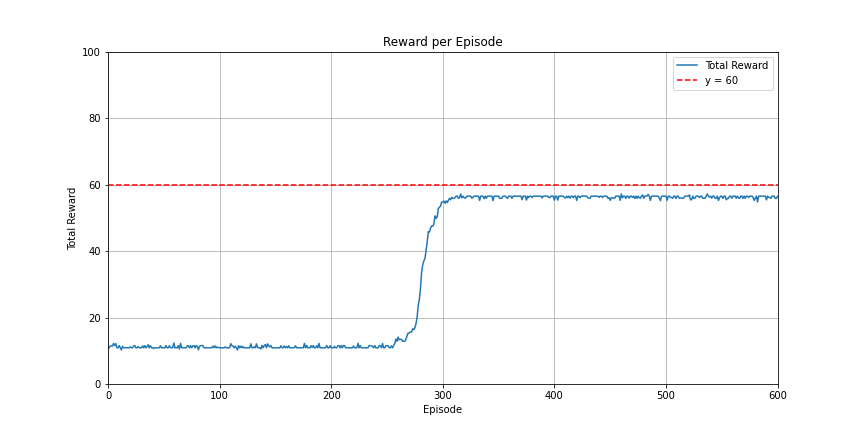

In [0]:
import matplotlib.pyplot as plt
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode")
plt.grid()
plt.axhline(y=60, color="red", linestyle="--", label="y = 60")
plt.xlim([0, 600])
plt.ylim([0,100])
plt.legend()
plt.show()



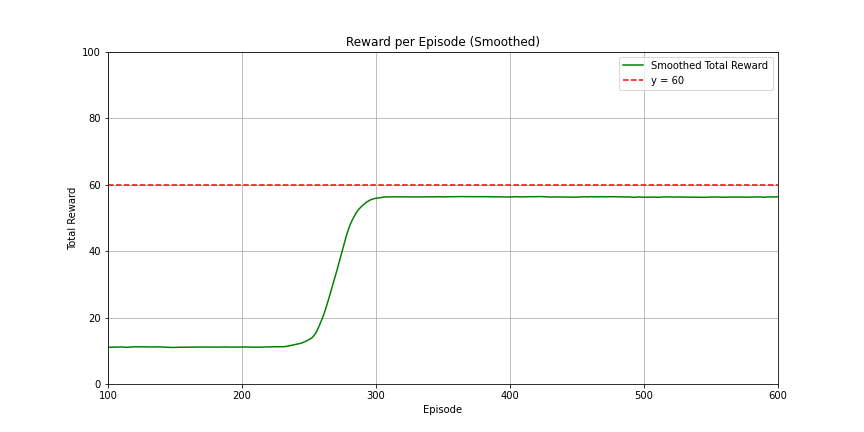

In [0]:
# Hàm tính trung bình động
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Áp dụng trung bình động cho episode_rewards
smoothed_rewards = moving_average(episode_rewards, window_size=25)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label="Smoothed Total Reward", color="green")
plt.axhline(y=60, color="red", linestyle="--", label="y = 60")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode (Smoothed)")
plt.legend()
plt.grid()
# Giới hạn trục x nếu cần
plt.xlim([100, 600])
plt.ylim([0,100])
plt.show()

In [0]:
from flask import jsonify
import json

def respGenerator(iterator):
    for token in iterator:
        resp = {
            'response': token
        }
        yield 'data: ' + json.dumps(resp) + '\n\n'

Imported flask 3.0.3 (pre-installed)
Imported json (pre-installed)


In [0]:
from flask import stream_with_context, Response
from sqlalchemy.exc import SQLAlchemyError

app = Flask("My App")

@app.before_request
def handle_preflight():
    if request.method == "OPTIONS":
        res = Response()
        res.headers['Access-Control-Allow-Origin'] = '*'
        res.headers['X-Content-Type-Options'] = '*'
        res.headers['Access-Control-Allow-Headers'] = '*'
        return res
        
@app.route("/generate", methods=["POST"])
def generate():
    data = request.json
    prompt = data.get("prompt", "")
    stream = data.get('stream', True)

    # Xử lý nếu prompt là danh sách
    if isinstance(prompt, list):
        prompt = " ".join([message['content'] for message in prompt])
        # prompt = " ".join([str(p) for p in prompt])
    # if isinstance(prompt, list):
    #     # Xử lý prompt thành chuỗi
    #     prompt = " ".join([str(p['content']) if isinstance(p, dict) and 'content' in p else str(p) for p in prompt])
    if stream:
        iterator = get_response(session, prompt)
        return Response(stream_with_context(respGenerator(iterator)), content_type='text/event-stream')

    response = rag_chain.invoke(prompt)
    return jsonify({"response": response})

    
@app.route("/update_feedback", methods=["POST"])
def update_feedback():
    data = request.json

    # Kiểm tra tham số đầu vào
    feedback_id = data.get("feedback_id")
    response_type = data.get("response_type")
    action = data.get("action")

    if not feedback_id or not response_type or not action:
        return jsonify({"error": "Thiếu thông tin cần thiết (feedback_id, response_type, action)"}), 400

    # Kiểm tra response_type và action hợp lệ
    if response_type not in ["response_1", "response_2"] or action not in ["like", "dislike"]:
        return jsonify({"error": "Thông tin response_type hoặc action không hợp lệ"}), 400

    try:
        # Truy vấn Feedback theo ID
        feedback = session.query(Feedback).filter_by(id=feedback_id).first()
        if not feedback:
            return jsonify({"error": "Không tìm thấy bản ghi Feedback"}), 404

        # Cập nhật giá trị thích hoặc không thích
        if response_type == "response_1":
            if action == "like":
                feedback.likes_1 += 1
            elif action == "dislike":
                feedback.dislikes_1 += 1
        elif response_type == "response_2":
            if action == "like":
                feedback.likes_2 += 1
            elif action == "dislike":
                feedback.dislikes_2 += 1

        # Lưu thay đổi
        session.commit()
        return jsonify({"message": "Cập nhật thành công"}), 200

    except SQLAlchemyError as e:
        session.rollback()
        return jsonify({"error": str(e)}), 500

    finally:
        session.close()


Imported flask 3.0.3 (pre-installed)
Imported sqlalchemy.exc (pre-installed)


In [0]:
app.run(threaded=True, debug=False, port=7889, host='0.0.0.0')


 * Serving Flask app 'My App'
 * Debug mode: off
IO Zep detects binding to 0.0.0.0. Your website/API can be accessed via https://zep.hcmute.fit/7889/
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:7889
 * Running on http://192.168.1.75:7889
Press CTRL+C to quit
Llama.generate: 1305 prefix-match hit, remaining 7 prompt tokens to eval


192.168.1.75 - - [07/Dec/2024 10:35:47] "POST /generate HTTP/1.1" 200 -
Chào bạn! Rất vui được chào đón bạn đến với chatbot tư vấn sinh viên của trường Đại học Sư phạm Kỹ thuật TP.HCM. 

Bạn có bất kỳ thắc mắc nào về tuyển sinh, đào tạo, chính sách học bổng hay các hoạt động khác của trường không? Mình sẽ cố gắng hết sức để giải đáp cho bạn một cách đầy đủ và chính xác nhất. 

Hãy cứ thoải mái đặt câu hỏi nhé!


llama_perf_context_print:        load time =   24293.86 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     7 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval ti